

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Practical Assignment 3
    <br>
     Hidden Markov Models -Bayes Net <br>
<font color=696880 size=4>
Amirardalan Dehghanpour


mohammadreza monemian  </br>
402106604


# HMM Assignment

 –Sequence Modeling with Hidden Markov Models (HMM)

## Part 1: HMM Models


Introduce the concept of Hidden Markov Models (HMMs) and their applications in sequence modeling.

### -What is an HMM?
A Hidden Markov Model is a statistical model that represents systems with:
1. **Hidden states** – not directly observable (e.g., phonemes, weather conditions, gene regions).
2. **Observable outputs** – emitted signals or features (e.g., audio features, weather observations).

### - Key Components of an HMM:
- **States (Z)**: Hidden variables (e.g., phonemes in speech recognition).
- **Observations (X)**: Observable features (e.g., MFCCs from audio).
- **Initial Probabilities (π)**: Probability of starting in a particular state.
- **Transition Probabilities (A)**: Probability of moving from one state to another.
- **Emission Probabilities (B)**: Probability of observing a value given a state.

### -HMM Process Overview:
At each time step `t`, the system:
1. Transitions from one state to another using **transition probability A**
2. Emits an observation using **emission probability B**

### - Why Use HMMs?
HMMs are useful for modeling sequential data where the underlying structure is hidden but can be inferred from observations.

#### Example Applications:
- **Speech Recognition** – Infer phonemes from audio features
- **Natural Language Processing** – POS tagging, named entity recognition
- **Bioinformatics** – Identify coding vs. non-coding DNA regions
- **Finance** – Regime detection in time series

---

 In this part, we will:
- Work with dna datasets
- Extract HMM parameters from data
- Implement HMM algorithms from scratch
- Visualize results to understand hidden sequences



## Part 2: Extract HMM Parameters from DNA Dataset ##

In this section, you'll use a labeled DNA dataset to extract the core parameters of a Hidden Markov Model:
- **Initial Probabilities** – likelihood of starting in a specific hidden state
- **Transition Matrix** – probabilities of switching from one hidden state to another
- **Emission Matrix** – probabilities of emitting a specific observation given the hidden state

We are given labeled sequences of DNA nucleotides with associated hidden states (`Coding` or `NonCoding`). Using this, we can compute the HMM parameters as follows:


####  Initial Probabilities (π)
- For each sequence, check the **first position** (Position == 1).
- Count how many times each hidden state appears at the start.
- Normalize the counts to get the starting probability distribution.

####  Transition Probabilities (A)
- For each sequence, look at every **pair of consecutive states** (from Position _t_ to _t+1_).
- Count how often each transition occurs (e.g., Coding → Coding, Coding → NonCoding).
- For each state, normalize its outgoing transition counts to sum to 1.

####  Emission Probabilities (B)
- For each state, count how frequently it emits each nucleotide (A, C, G, T).
- Normalize these counts within each state.

This method is based on **maximum likelihood estimation(MLE)** using frequency counts, which is valid because we have access to the true hidden states.
These parameters will be used in later for performing inference (Forward/Viterbi).



 ## Load the Dataset ##

In [12]:
# Load the synthetic DNA dataset
# It contains Sequence_ID, Position, Nucleotide (A/C/G/T), and State (Coding/NonCoding).

import pandas as pd
import numpy as np
#TODO
data = pd.read_csv("./dna_dataset.csv")
print(data.head())
# Load dataset
# Preview the data

   Sequence_ID  Position Nucleotide      State
0            1         1          A     Coding
1            1         2          G  NonCoding
2            1         3          G     Coding
3            1         4          A  NonCoding
4            1         5          T     Coding


## Identify Unique States and Observations ##

In [13]:
# Get the unique hidden states and observable symbols (nucleotides).
# This helps us define our state and observation spaces for the HMM.
# TODO:
states = data['State'].unique()
observations = data['Nucleotide'].unique()
print(states)
print(observations)


['Coding' 'NonCoding']
['A' 'G' 'T' 'C']


## Estimate Initial Probabilities (π) ##

In [14]:
# Compute the probability of starting in each state.
# This is based on the first position of each sequence in the dataset.

# TODO: Count how often each state appears as the first state in a sequence
initial_probs = {}
first = data[data['Position'] == 1]
initial_probs['Coding'] = len(first[first['State'] == 'Coding'])/len(first)
initial_probs['NonCoding'] = len(first[first['State'] == 'NonCoding'])/len(first)

print("Initial Probabilities (π):", initial_probs)


Initial Probabilities (π): {'Coding': 0.49, 'NonCoding': 0.51}


## Estimate Transition Probabilities (A) ##

In [15]:
# Compute the probability of transitioning from one hidden state to another.
# Based on how states change within each sequence.

# TODO: Count transitions between states
transition_probs = {'Coding' : {} , 'NonCoding' : {}}
code_code=0
code_noncode=0
noncode_code=0
noncode_noncode = 0
for i in range(0,len(data)-1) :
  if data.iloc[i]["Sequence_ID"] == data.iloc[i+1]["Sequence_ID"] :
    if data.iloc[i]['State'] == "Coding"  :
      if data.iloc[i+1]["State"] == "Coding" :
        code_code += 1
      else :
        code_noncode += 1
    else :
      if data.iloc[i+1]["State"] == "Coding" :
        noncode_code += 1
      else :
        noncode_noncode  += 1

transition_probs['Coding']['Coding'] = code_code /(code_code + code_noncode)
transition_probs['Coding']['NonCoding'] = code_noncode /(code_code + code_noncode)
transition_probs['NonCoding']['Coding'] = noncode_code /(noncode_code + noncode_noncode)
transition_probs['NonCoding']['NonCoding'] = noncode_noncode /(noncode_code + noncode_noncode)


print("Transition Probabilities (A):")
for from_state, to_probs in transition_probs.items():
    print(from_state, "→", to_probs)


Transition Probabilities (A):
Coding → {'Coding': 0.4450775142440705, 'NonCoding': 0.5549224857559295}
NonCoding → {'Coding': 0.5823615160349854, 'NonCoding': 0.4176384839650146}


## Estimate Emission Probabilities (B) ##

In [17]:
# Compute the probability of emitting a given nucleotide from each hidden state.
# Based on how frequently each nucleotide appears for a given state.

# TODO: Count emissions for each (state, observation) pair
emission_probs = {'Coding' : {} , 'NonCoding' : {}}
Cod_A = len(data[(data["State"] == "Coding") & (data["Nucleotide"] == "A")])
Cod_C = len(data[(data["State"] == "Coding") & (data["Nucleotide"] == "C")])
Cod_G = len(data[(data["State"] == "Coding") & (data["Nucleotide"] == "G")])
Cod_T = len(data[(data["State"] == "Coding") & (data["Nucleotide"] == "T")])
Non_Cod_A = len(data[(data["State"] == "NonCoding") & (data["Nucleotide"] == "A")])
Non_Cod_C = len(data[(data["State"] == "NonCoding") & (data["Nucleotide"] == "C")])
Non_Cod_G = len(data[(data["State"] == "NonCoding") & (data["Nucleotide"] == "G")])
Non_Cod_T = len(data[(data["State"] == "NonCoding") & (data["Nucleotide"] == "T")])

emission_probs["Coding"]["A"] = Cod_A /(Cod_A + Cod_C + Cod_G +Cod_T)
emission_probs["Coding"]["C"] = Cod_C /(Cod_A + Cod_C + Cod_G +Cod_T)
emission_probs["Coding"]["G"] = Cod_G /(Cod_A + Cod_C + Cod_G +Cod_T)
emission_probs["Coding"]["T"] = Cod_T /(Cod_A + Cod_C + Cod_G +Cod_T)
emission_probs["NonCoding"]["A"] = Non_Cod_A /(Non_Cod_A + Non_Cod_C + Non_Cod_G +Non_Cod_T)
emission_probs["NonCoding"]["C"] = Non_Cod_C /(Non_Cod_A + Non_Cod_C + Non_Cod_G +Non_Cod_T)
emission_probs["NonCoding"]["G"] = Non_Cod_G /(Non_Cod_A + Non_Cod_C + Non_Cod_G +Non_Cod_T)
emission_probs["NonCoding"]["T"] = Non_Cod_T /(Non_Cod_A + Non_Cod_C + Non_Cod_G +Non_Cod_T)





print("Emission Probabilities (B):")
for state, probs in emission_probs.items():
    print(state, "→", probs)


Emission Probabilities (B):
Coding → {'A': 0.2556261195245074, 'C': 0.2506757857026543, 'G': 0.24950333821853118, 'T': 0.2441947565543071}
NonCoding → {'A': 0.35343915343915344, 'C': 0.14794333504010923, 'G': 0.1501962792285373, 'T': 0.3484212322922}


## Part 4: Forward Algorithm (Filtering with Elapse Time + Observation)

The **Forward Algorithm** helps us compute the probability of an observation sequence in a Hidden Markov Model (HMM). It also gives us the belief about the system's hidden state at each time step.

To do this, it recursively applies two updates at each time step `t`:


###  Step 1: Elapse Time (Prediction)
Predict the probability of being in each hidden state at time `t`, before seeing the new observation:

$$
P(x_t | e_{1:t-1}) = \sum_{x_{t-1}} P(x_t | x_{t-1}) \cdot P(x_{t-1} | e_{1:t-1})
$$

This uses the **transition probabilities (A)** and previous beliefs.


###  Step 2: Observation Update (Bayesian Update)
Once we see the new observation `e_t`, we update our beliefs:

$$
P(x_t | e_{1:t}) \propto P(e_t | x_t) \cdot P(x_t | e_{1:t-1})
$$

This uses the **emission probabilities (B)** and normalizes the result.


### Final Result:
- We maintain a belief `α_t(x)` for each state `x` at every time step.
- We can compute the total probability of the sequence by summing the final α values.



In [25]:
def elapse_time(prior, transition_probs, states):
    """
    Predicts the belief at time t using the belief at time t-1 and transition matrix A.

    Parameters:
    - prior: dict of P(state at t-1 | evidence up to t-1)
    - transition_probs: dict of dicts P(to_state | from_state)
    - states: list of possible states


    Returns:
    - prediction: dict of P(state at t | evidence up to t-1)
    """

    prediction = {}
    for to_state in states:
        prediction[to_state] = sum(
            prior[from_state] * transition_probs[from_state][to_state]
            for from_state in states
        )
    return prediction




In [29]:
def observe(predicted, observation, emission_probs, states):
    """
    Updates the belief at time t after seeing observation e_t, using emission matrix B.

    Parameters:
    - predicted: dict of P(state at t | evidence up to t-1)
    - observation: the observed symbol at time t (e.g., 'A')
    - emission_probs: dict of dicts P(obs | state)
    - states: list of possible states

    Returns:
    - updated: dict of P(state at t | evidence up to t)
    """

    updated = {}
    total = 0
    for state in states:
        updated[state] = emission_probs[state][observation] * predicted[state]
        total += updated[state]


    for state in states:
        updated[state] /= total

    return updated


In [30]:
def forward_algorithm(observation_sequence, states, start_probs, transition_probs, emission_probs):
    """
    Runs the full forward algorithm over an observation sequence.

    Parameters:
    - observation_sequence: list of observations (e.g., ['A', 'C', 'T', ...])
    - states: list of hidden states
    - start_probs: initial state distribution (π)
    - transition_probs: transition matrix A
    - emission_probs: emission matrix B


    Returns:
    - alpha_list: list of belief dicts (α_t) over time
    - sequence_prob: total probability of the full observation sequence
    """
    alpha_list = []
    elpased_till_now = start_probs.copy()
    observed_till_now = {}
    for i in range(len(observation_sequence)) :
      observed_till_now = observe(elpased_till_now,observation_sequence[i] , emission_probs, states)
      elpased_till_now  = elapse_time(observed_till_now, transition_probs, states)
      alpha_list.append(observed_till_now )
      sequence_prob = sum(observed_till_now.values())

    return alpha_list,sequence_prob






In [31]:
# Small test case
test_sequence = ['A','C','C','T','T','T','A','G']

# Run forward algorithm
alpha_vals, prob = forward_algorithm(
    test_sequence,
    states,
    initial_probs,
    transition_probs,
    emission_probs
)

print(f"\nTotal probability of sequence {test_sequence}: {prob:.6f}")
print("\nBelief at final time step:")
for state, p in alpha_vals[-1].items():
    print(f"P({state}) = {p:.4f}")



Total probability of sequence ['A', 'C', 'C', 'T', 'T', 'T', 'A', 'G']: 1.000000

Belief at final time step:
P(Coding) = 0.6443
P(NonCoding) = 0.3557


## Part 5: Viterbi Algorithm – Most Likely State Sequence

While the Forward Algorithm gives us the probability of a sequence of observations, the **Viterbi Algorithm** answers a different question:

> What is the **most likely sequence of hidden states** that could have generated this observation sequence?



The Viterbi Algorithm is a dynamic programming approach. At each time step `t`, it keeps track of:

- The **highest probability path** to each state.
- A **backpointer** that tells us which state led to that one.

###  Two Main Steps:

1. **Recursion (Forward Pass):**
$$
\delta_t(s) = \max_{s'} [\delta_{t-1}(s') \cdot P(s | s')] \cdot P(obs_t | s)
$$

2. **Backtracking (Backward Pass):**
$$
\text{Backtrace from final best state} \rightarrow \text{recover most likely path}
$$





In [ ]:
def viterbi(obs, states, start_p, trans_p, emit_p):
    """
    Viterbi algorithm to find the most probable sequence of hidden states.

    Parameters:
    - obs: list of observations (e.g., ['A', 'C', 'T', ...])
    - states: list of hidden states (e.g., ['Coding', 'NonCoding'])
    - start_p: initial state probabilities
    - trans_p: transition probability matrix
    - emit_p: emission probability matrix

    Returns:
    - prob: probability of the most likely state sequence
    - path: list of most likely hidden states
    """
    V = [{}]
    path = {}

    for s in states:
        V[0][s] = start_p[s] * emit_p[s][obs[0]]
        path[s] = [s]

    for t in range(1, len(obs)):
        V.append({})
        new_path = {}

        for curr_state in states:
            (prob, prev_state) = max(
                (V[t-1][s] * trans_p[s][curr_state] * emit_p[curr_state][obs[t]], s)
                for s in states
            )
            V[t][curr_state] = prob
            new_path[curr_state] = path[prev_state] + [curr_state]

        path = new_path

    n = len(obs) - 1
    (final_prob, final_state) = max((V[n][s], s) for s in states)
    return final_prob, path[final_state]


In [ ]:
obs_seq = ['A', 'C', 'G', 'T', 'A','A', 'C', 'C', 'C', 'A']

prob, most_likely_path = viterbi(
    obs_seq,
    states,
    initial_probs,
    transition_probs,
    emission_probs
)

print("Observation sequence:", obs_seq)
print("Most likely state sequence:", most_likely_path)
print("Probability of this path:", prob)



Observation sequence: ['A', 'C', 'G', 'T', 'A', 'A', 'C', 'C', 'C', 'A']
Most likely state sequence: ['NonCoding', 'Coding', 'Coding', 'NonCoding', 'Coding', 'NonCoding', 'Coding', 'Coding', 'Coding', 'NonCoding']
Probability of this path: 5.879383986938688e-09


## Part 6: Visualizing the Most Likely Hidden State Sequence (Viterbi Path)

After using the Viterbi algorithm, we get the **most likely sequence of hidden states** that could have produced the given observations.

In this part, we'll:
1. Visually display the Viterbi path over time.
2. Compare it with the **true hidden state sequence** (if known).
3. Visualize it on top of the **Forward Algorithm belief heatmap**.

This helps understand where the model is confident, where it might be uncertain, and how accurate the predictions are.


In [ ]:
import matplotlib.pyplot as plt

def plot_viterbi_path(viterbi_path, states, true_path=None, title="Viterbi Most Likely Path"):
    """
    Plots the Viterbi path as a step function timeline of states.

    Parameters:
    - viterbi_path: list of predicted states from Viterbi algorithm
    - states: list of possible hidden states (e.g., ['NonCoding', 'Hidden', 'Coding'])
    - true_path: optional list of true hidden states for comparison
    - title: title for the plot
    """
    plt.figure(figsize=(12, 6))

    # Create mapping from states to y-values
    state_to_y = {state: i for i, state in enumerate(states)}

    # Prepare data for step plot
    x = range(len(viterbi_path))
    y = [state_to_y[state] for state in viterbi_path]

    # Plot Viterbi path as step function
    plt.step(x, y, where='post', linewidth=2.5, color='r', label='Viterbi Path')

    # Plot markers at each step
    plt.plot(x, y, 'bo', markersize=10, markeredgewidth=2, markerfacecolor='white')

    # Plot true path if available
    if true_path is not None:
        true_y = [state_to_y[state] for state in true_path]
        plt.step(x, true_y, where='post', linewidth=2, linestyle=':', color='g', label='True Path')
        plt.plot(x, true_y, 'gx', markersize=10, markeredgewidth=2)

    # Customize plot
    plt.yticks(range(len(states)), states)
    plt.xticks(x)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Hidden State', fontsize=12)
    plt.title(title, fontsize=14, pad=20)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc='upper right')

    # Add state labels
    for i, state in enumerate(viterbi_path):
        plt.text(i, state_to_y[state], state,
                ha='center', va='bottom',
                fontsize=11, color='b',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

    plt.tight_layout()
    plt.show()

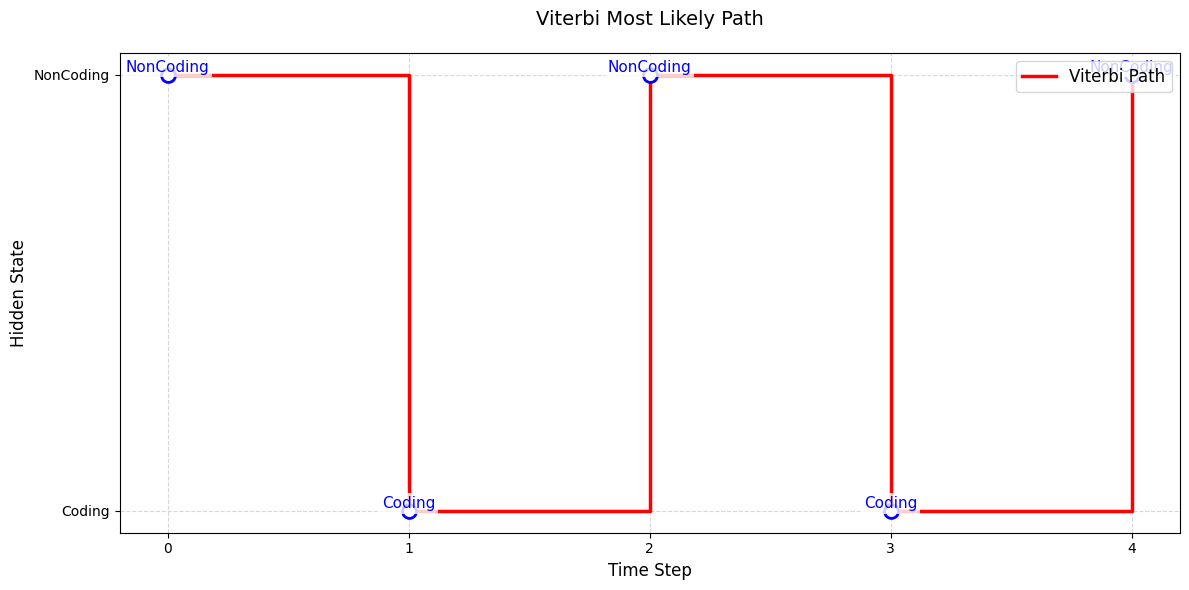

In [ ]:
# Run Viterbi on example observation sequence
obs_seq = ['A', 'C', 'T', 'G', 'A']
prob, viterbi_path = viterbi(obs_seq, states, initial_probs, transition_probs, emission_probs)

# Plot the path
plot_viterbi_path(viterbi_path, states)


# Bayesian Networks

In this assignment, we will work with a Bayesian Network based on a scenario: **a group of friends deciding whether to order pizza** and how that decision, along with other factors, affects their evening satisfaction.

We'll learn how to:
- Represent a Bayesian Network
- Define its conditional probability tables (CPTs)
- Implement inference algorithms

---

## Scenario

Imagine a group of friends planning their evening. They may or may not be hungry. It might be a weekend. These factors influence whether they decide to order pizza. If pizza is ordered **and** friends are free, they might plan a movie night. The presence of a movie night then affects how satisfied they are.

---

## 🔍 Variables

| Variable | Description | Values |
|----------|-------------|--------|
| `H` | It's a hungry day | {True, False} |
| `W` | It's the weekend | {True, False} |
| `P` | They order pizza | {True, False} |
| `F` | Friends are free | {True, False} |
| `M` | Movie night is planned | {True, False} |
| `S` | Satisfaction level | {'high', 'medium', 'low'} |

---

## 🔗 Network Structure

The relationships among the variables and their conditional probablities follow these tables:

### P(H) — Hungry
| H     | P(H) |
|-------|------|
| True  | 0.6  |
| False | 0.4  |

### P(W) — Weekend
| W     | P(W) |
|-------|------|
| True  | 0.3  |
| False | 0.7  |

### P(F) — Friends Free
| F     | P(F) |
|-------|------|
| True  | 0.8  |
| False | 0.2  |

### P(P | H, W) — Pizza
| H     | W     | P(P=True) | P(P=False) |
|-------|-------|-----------|------------|
| True  | True  | 0.95      | 0.05       |
| True  | False | 0.7       | 0.3        |
| False | True  | 0.5       | 0.5        |
| False | False | 0.1       | 0.9        |

### P(M | P, F) — Movie Night
| P     | F     | P(M=True) | P(M=False) |
|-------|-------|-----------|------------|
| True  | True  | 0.9       | 0.1        |
| True  | False | 0.4       | 0.6        |
| False | True  | 0.6       | 0.4        |
| False | False | 0.2       | 0.8        |

### P(S | M) — Satisfaction
| M     | S        | P(S)   |
|-------|----------|--------|
| True  | high     | 0.7    |
|       | medium   | 0.25   |
|       | low      | 0.05   |
| False | high     | 0.1    |
|       | medium   | 0.3    |
|       | low      | 0.6    |




###  Step 1: Define and Visualize the Bayesian Network
#### Your task in this step:
##### 1. Draw the Bayesian Network using networkx and matplotlib
##### 2. Create a dictionary called `bayes_net` that stores all variables, their parents, and their CPTs

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

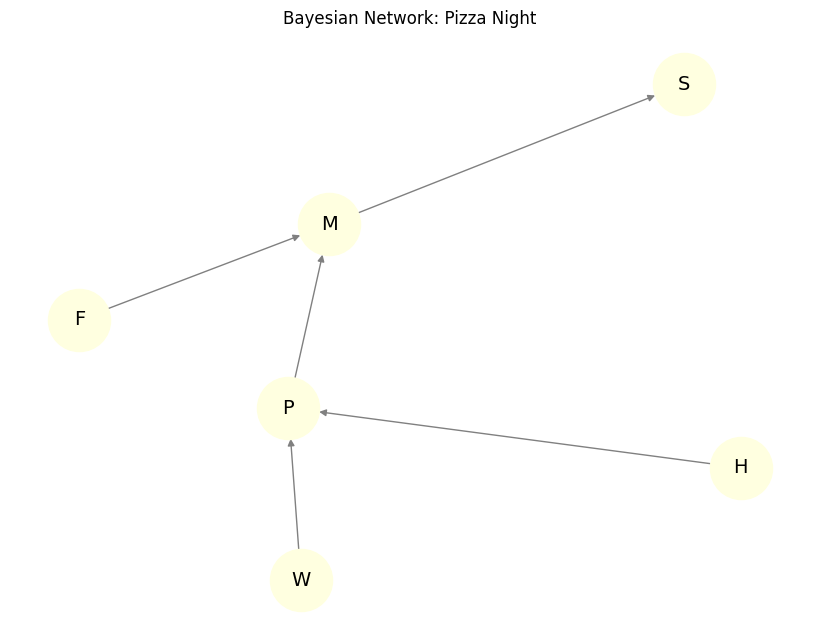

0.7


In [2]:
# === STEP 1: Define and Visualize the Bayesian Network ===
# ---------------------------------------------------------

# Your tasks in this step:
# 1. Draw the Bayesian Network using networkx and matplotlib
# 2. Define the Bayesian Network structure and CPTs using a dictionary
# 3. Implement a helper function to retrieve probabilities from CPTs

# --- TODO: Draw the graph ---

import networkx as nx
import matplotlib.pyplot as plt

# 📌 TODO: Create a directed graph and add edges between variables
G = nx.DiGraph()

# Add edges based on the Pizza Night Bayes Net
# Example: G.add_edge('H', 'P')
# TODO: Add the correct edges here
# G.add_edge(...)
G.add_edge('H','P')
G.add_edge('W','P')
G.add_edge('P', 'M')
G.add_edge('F','M')
G.add_edge('M' ,'S')

# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightyellow',
        font_size=14, edge_color='gray')
plt.title("Bayesian Network: Pizza Night")
plt.show()


# --- TODO: Define the Bayesian Network as a dictionary ---

bayes_net = {
    'H': {
        'parents': [],
        'cpt': {
            True: 0.6,
            False: 0.4
        }
    },
     'W': {
        'parents': [],
        'cpt': {
            True: 0.3,
            False: 0.4
        }
    },
     'F': {
        'parents': [],
        'cpt': {
            True: 0.8,
            False: 0.2
        }
    },
     'P' : {
         'parents' : ['H','W'],
         'cpt' : {
             (True,True) : {True : 0.95 , False : 0.05},
             (True,False) : {True : 0.7 , False : 0.3},
             (False,True) : {True : 0.5 , False : 0.5},
             (False,False) : {True : 0.1 , False : 0.9},
         }

     },
    'M' : {
         'parents' : ['P','F'],
         'cpt' : {
             (True,True) : {True : 0.9 , False : 0.1},
             (True,False) : {True : 0.4 , False : 0.6},
             (False,True) : {True : 0.6 , False : 0.4},
             (False,False) : {True : 0.2 , False : 0.8},
         }

     },
    'S' : {
         'parents' : ['M'],
         'cpt' : {
             (True) : {'high' : 0.7 , 'medium' : 0.25 , 'low' : 0.05},
             (False) : {'high' : 0.1 , 'medium' : 0.3 , 'low' : 0.6},
         }

     },


    #  Define all remaining variables (W, F, P, M, S) with their CPTs
}


def get_prob(var, value, evidence, bayes_net):
    """
    Return the probability of var = value given evidence,
    based on the structure and CPTs in the bayes_net dictionary.
    """
    node = bayes_net[var]
    parents = node['parents']
    cpt = node['cpt']

    if not parents:
        return cpt[value]
    else:
        try:
            if len(parents) == 1:
                key = evidence[parents[0]]
            else:
                key = tuple(evidence[parent] for parent in parents)
        except KeyError as e:
            raise ValueError(f"Missing parent '{e.args[0]}' for variable '{var}' in evidence.")

        return cpt[key][value]

# Test your implementation below with this query:
# What is P(P=True | H=True, W=False)?
print(get_prob('P', True, {'H': True, 'W': False}, bayes_net))


# Step 2: Inference by Enumeration

In this step, you'll implement **exact inference** in a Bayesian Network using the **enumeration algorithm**.

---

##  Goal :

We want to compute the probability of a **query variable** given some **evidence**.  
For example:

$$
P(S = \text{high} \mid H = \text{True}, W = \text{True})
$$

To do this, we'll use:

1. **A recursive function `enumerate_all`**  
   - Loops through all hidden variables and sums over them
   - Multiplies conditional probabilities using the Bayesian Network

2. **A main function `query_enum`**  
   - Computes the numerator: probability of the query value given evidence
   - Computes the denominator: normalization over all possible values of the query variable
   - Returns the final **normalized probability**

---






In [3]:
# === STEP 2: Inference by Enumeration ===
# ----------------------------------------

# Your goal in this step:
# Implement exact inference using the enumeration algorithm.

# Given a query variable and some evidence, compute:
#     P(query_var = query_val | evidence)

# Utility: Variables in topological order
variables = ['H', 'W', 'F', 'P', 'M', 'S']

#TODO: Implement the recursive enumeration function ---
def get_possible_values(var, bayes_net):
    """
    Return all possible values for a variable based on its CPT structure
    """
    node = bayes_net[var]
    cpt = node['cpt']

    if not node['parents']:
        # For root nodes
        if isinstance(cpt, dict):
            # Handle cases like 'H': {True: 0.6, False: 0.4}
            if all(isinstance(k, tuple) for k in cpt.keys()):
                # If keys are tuples (like (True,)), extract first element
                return list(set(k[0] for k in cpt.keys()))
            else:
                # Regular case with direct keys
                return list(cpt.keys())

    else:
        # For child nodes, examine the first entry in the nested CPT
        first_entry = next(iter(cpt.values()))
        if isinstance(first_entry, dict):
            return list(first_entry.keys())



def enumerate_all(vars_left, evidence, bayes_net):
    """
    Recursively compute the total probability of an assignment
    using the chain rule of probability.

    Args:
        vars_left: list of variables to process
        evidence: current assignment of known variables
        bayes_net: dictionary of CPTs

    Returns:
        total probability of the current evidence
    """
    if not vars_left:
        return 1.0

    current_var = vars_left[0]
    remaining_vars = vars_left[1:]

    if current_var in evidence:
        value = evidence[current_var]
        prob = get_prob(current_var, value, evidence, bayes_net)
        return prob * enumerate_all(remaining_vars, evidence, bayes_net)
    else:
        total = 0.0
        possible_values = get_possible_values(current_var, bayes_net)

        for value in possible_values:
            new_evidence = evidence.copy()
            new_evidence[current_var] = value
            prob = get_prob(current_var, value, new_evidence, bayes_net)
            total += prob * enumerate_all(remaining_vars, new_evidence, bayes_net)

        return total

#TODO: Implement the main query function ---
def query_enum(query_var, query_val, evidence, bayes_net):
    """
    Compute P(query_var = query_val | evidence) using normalization.

    Args:
        query_var: the variable we want to ask about
        query_val: the specific value we're querying
        evidence: dictionary of known values
        bayes_net: full network

    Returns:
        Normalized probability of the query given the evidence
    """
    numerator_evidence = evidence.copy()
    numerator_evidence[query_var] = query_val
    numerator = enumerate_all(variables, numerator_evidence, bayes_net)

    # Compute denominator: P(evidence) = sum over all possible query values
    denominator = 0.0
    possible_values = get_possible_values(query_var, bayes_net)

    for value in possible_values:
        denominator_evidence = evidence.copy()
        denominator_evidence[query_var] = value
        denominator += enumerate_all(variables, denominator_evidence, bayes_net)
    if denominator == 0:
        return 0.0  # To handle division by zero

    return numerator / denominator


In [9]:
#  Example: P(S='high' | H=True, W=True)
import time

# Start time
start_time = time.perf_counter()

# Run the query
result = query_enum('S', 'high', {'H': True, 'W': True}, bayes_net)

# End time
end_time = time.perf_counter()

# Calculate execution time in milliseconds
execution_time_ms = (end_time - start_time) * 1000

print(f"P(S = 'high' | H=True, W=True) = {result:.4f}")
print(f"Execution time: {execution_time_ms:.2f} ms")

P(S = 'high' | H=True, W=True) = 0.5716
Execution time: 0.28 ms


#  Step 3: Inference with Variable Elimination

In this step, you will implement **inference using Variable Elimination** — an exact, more efficient alternative to Enumeration.

---

## Core Ideas:

- Instead of computing the full joint distribution, we work with **factors**.
- A factor is a table mapping variable assignments to probabilities.
- We **join factors** together (multiplication).
- We **eliminate hidden variables** (sum them out).
- At the end, we normalize the final factor.

---

## Inputs
- `query_var`: The variable we're asking about (e.g. `'S'`)
- `query_val`: The value we want (e.g. `'high'`)
- `evidence`: Observed variables
- `bayes_net`: The full Bayesian Network

---

## What You’ll Implement
1. **Factor Construction**: Build initial factors from CPTs.
2. **Restrict for Evidence**: Incorporate evidence early by pruning CPTs.
3. **Join**: Combine factors that mention the same variable.
4. **Eliminate**: Marginalize out variables not in the query or evidence.
5. **Normalize**: Get valid probability distribution.

---



In [7]:
from itertools import product
from copy import deepcopy
from functools import reduce

def get_possible_values(var, bayes_net):
    """Helper function to get possible values of a variable from its CPT"""
    node = bayes_net[var]
    if not node['parents']:
        if isinstance(node['cpt'], dict):
            if all(isinstance(k, tuple) for k in node['cpt'].keys()):
                return list(set(k[0] for k in node['cpt'].keys()))
            return list(node['cpt'].keys())
    else:
        first_entry = next(iter(node['cpt'].values()))
        return list(first_entry.keys())

# === STEP 3: Variable Elimination ===
# ------------------------------------

#TODO: Build a Factor from CPT and Evidence
def make_factor(var, bayes_net, evidence):
    """
    Build a factor for a given variable using its CPT.
    Apply the evidence to skip inconsistent assignments.

    - Get the variable's parents from the Bayes net.
    - Define the domain of each variable (e.g., True/False or high/medium/low).
    - Loop through all combinations of parent and variable values.
    - Skip entries that contradict the evidence.
    - Extract the correct probability from the CPT.
    - Store each valid assignment and its probability in the factor.

    Returns a dictionary with:
    - 'vars': list of variables in the factor
    - 'table': mapping from value assignments (tuples) to probabilities
    """
    node = bayes_net[var]
    parents = node['parents']
    cpt = node['cpt']

    # Determine all variables in this factor
    factor_vars = parents + [var]

    # Get domains for each variable
    domains = {v: get_possible_values(v, bayes_net) for v in factor_vars}

    factor = {'vars': factor_vars, 'table': {}}

    # Generate all possible assignments
    for assignment in product(*[domains[v] for v in factor_vars]):
        # Check if assignment contradicts evidence
        consistent = True
        for evar, evalue in evidence.items():
            if evar in factor_vars and assignment[factor_vars.index(evar)] != evalue:
                consistent = False
                break
        if not consistent:
            continue

        # Get probability from CPT
        if not parents:
            prob = cpt[assignment[0]] if not isinstance(cpt, dict) or not all(isinstance(k, tuple) for k in cpt.keys()) else cpt[(assignment[0],)]
        else:
            parent_values = assignment[:-1]
            key = parent_values[0] if len(parent_values) == 1 else parent_values
            prob = cpt[key][assignment[-1]]

        # Store in factor table
        factor['table'][assignment] = prob

    return factor

#TODO: Join Two Factors Together
def join_factors(f1, f2):
    """
    Multiply two factors together to combine their probability tables.

    - Determine the full list of variables across both factors.
    - Loop over all possible assignments to these variables.
    - For each assignment:
        - Extract the relevant sub-assignments for f1 and f2.
        - Multiply the two probabilities (if both exist).
        - Store the result in the new factor.

    Returns a new joined factor with merged variables and probabilities.
    """
    # Find common and all variables
    all_vars = f1['vars'] + [v for v in f2['vars'] if v not in f1['vars']]

    # Get domains for each variable
    domains = {}
    for v in all_vars:
        if v in f1['vars']:
            domains[v] = list(set(a[f1['vars'].index(v)] for a in f1['table'].keys()))
        else:
            domains[v] = list(set(a[f2['vars'].index(v)] for a in f2['table'].keys()))

    new_factor = {'vars': all_vars, 'table': {}}

    # Generate all possible assignments
    for assignment in product(*[domains[v] for v in all_vars]):
        # Get sub-assignments for each factor
        f1_assignment = tuple(assignment[all_vars.index(v)] for v in f1['vars'])
        f2_assignment = tuple(assignment[all_vars.index(v)] for v in f2['vars'])

        # Multiply probabilities if both exist
        if f1_assignment in f1['table'] and f2_assignment in f2['table']:
            prob = f1['table'][f1_assignment] * f2['table'][f2_assignment]
            new_factor['table'][assignment] = prob

    return new_factor

#TODO: Eliminate a Variable from a Factor
def eliminate(var, factor):
    """
    Eliminate a variable from a factor by summing over all its values.

    - Remove the eliminated variable from the factor's variable list.
    - For each assignment:
        - Sum over all values of the eliminated variable.
        - Accumulate the total probability in the new factor.

    Returns a new factor without the eliminated variable.
    """
    if var not in factor['vars']:
        return deepcopy(factor)

    # New factor without the eliminated variable
    new_vars = [v for v in factor['vars'] if v != var]
    new_factor = {'vars': new_vars, 'table': {}}

    # Group assignments by the remaining variables
    assignments = {}
    for full_assignment, prob in factor['table'].items():
        # Create key without the eliminated variable
        key = tuple(full_assignment[factor['vars'].index(v)] for v in new_vars)

        if key not in assignments:
            assignments[key] = 0.0
        assignments[key] += prob

    new_factor['table'] = assignments
    return new_factor

#TODO: Implement Variable Elimination Inference
def query_ve(query_var, query_val, evidence, bayes_net):
    """
    Use variable elimination to compute P(query_var = query_val | evidence).

    Steps:
    1. Build initial factors for all variables using `make_factor`.
    2. Identify all hidden variables (not in evidence or the query).
    3. For each hidden variable:
        - Find all factors containing it.
        - Join those factors using `join_factors`.
        - Eliminate the variable using `eliminate`.
        - Replace old factors with the reduced one.
    4. Join all remaining factors.
    5. Eliminate any remaining variables except the query.
    6. Normalize the result and return the final probability.

    Returns the normalized probability of the query value.
    """
    # Step 1: Build initial factors
    factors = [make_factor(var, bayes_net, evidence) for var in bayes_net.keys()]

    # Step 2: Identify hidden variables (not in evidence or query)
    observed_vars = set(evidence.keys()).union({query_var})
    hidden_vars = [var for var in bayes_net.keys() if var not in observed_vars]

    # Step 3: Eliminate hidden variables one by one
    for var in hidden_vars:
        # Find factors containing this variable
        relevant_factors = [f for f in factors if var in f['vars']]
        factors = [f for f in factors if var not in f['vars']]  # Remove them

        if not relevant_factors:
            continue

        # Join all relevant factors
        if len(relevant_factors) > 1:
            joined = reduce(join_factors, relevant_factors)
        else:
            joined = relevant_factors[0]

        # Eliminate the variable
        reduced = eliminate(var, joined)
        factors.append(reduced)

    # Step 4: Join all remaining factors
    if len(factors) > 1:
        final_factor = reduce(join_factors, factors)
    else:
        final_factor = factors[0] if factors else None

    # Step 5: Normalize
    if not final_factor or query_var not in final_factor['vars']:
        return 0.0

    # Create a dictionary mapping assignments to probabilities
    prob_dict = {}
    for assignment, prob in final_factor['table'].items():
        # Get the value of the query variable in this assignment
        q_index = final_factor['vars'].index(query_var)
        q_val = assignment[q_index]

        if q_val not in prob_dict:
            prob_dict[q_val] = 0.0
        prob_dict[q_val] += prob

    # Normalize
    total = sum(prob_dict.values())
    if total == 0:
        return 0.0

    return prob_dict.get(query_val, 0.0) / total

In [11]:
# Test: What is P(S='high' | H=True, W=True)?
import time

# Start time
start_time = time.perf_counter()

# Run the query
result_ve = query_ve('S', 'high', {'H': True, 'W': True}, bayes_net)

# End time
end_time = time.perf_counter()

# Calculate execution time in milliseconds
execution_time_ms = (end_time - start_time) * 1000

print(f"P(S = 'high' | H=True, W=True) = {result_ve:.4f}")
print(f"Execution time: {execution_time_ms:.2f} ms")

P(S = 'high' | H=True, W=True) = 0.5716
Execution time: 0.22 ms


ه
## Compare Enumeration vs. Variable Elimination
Explain your answer in each question
1. Do both methods return the **same probability** for your chosen query and evidence? Why or why not?

2. Which method was **faster** in your tests? Provide the execution times.

3. Why is **Variable Elimination** usually more efficient than Enumeration, especially for larger networks?

4. Can you think of a scenario where Enumeration might be **simpler or more appropriate** to use than VE?

5. What would happen to the performance of each method if the number of variables doubled? Try to explain without coding it.


Your Answer:
<br>
<br>
<div dir="rtl" style="font-size:22px; color:blue;">
<font color=orange size=4>
  1.بله به این خاطر که در هر دو روش به صورت دقیق احتمال محاسبه می شود و تقریبی وجود ندارد بنابراین مقدار به دست آمده در هر دو یکی خواهد بود .
  <br>
  2.انتظار می رود که متود elimination سریعتر باشد.زمانهای اجرا را نیز چاپ کردیم البته به خاطر کوچک یودن baysnet ممکن است خیلی تفاوتی نکند .
  <br>
  3.به خاطر اینکه در این حالت تمام joint  
  محاسبه نمیشود و با جدول های بزرگ سر و کار نداریم به این خاطر که هر بار متغیری
  eleiminate
  میشود نه اینکه همه با هم join شده و بعد دست به حذف متغیر ها بزنیم.
  <br>
  4.اگر شبکه بیزی متغیرهای بسیار کمی داشته باشد (مثلاً ۲ تا ۳ متغیر)، محاسبهٔ تمام حالات ممکن چنان ساده است که نیازی به روش‌های پیچیده‌تر نیست.
  <br>
  یا اینکه اگر بخواهیم تمام احتمالات مشترک را محاسبه کنیم (نه فقط یک استنتاج خاص)، Enumeration مستقیم‌تر است.
  <br>
  5.مشکل اصلی حالت enumration: محاسبه تمام حالات ممکن فضای جستجو (Exponential Growth).
اگر متغیرها دوبرابر شوند:
تعداد ورودی‌های جدول توزیع احتمال مشترک به صورت نمایی افزایش می‌یابد
<br>
پیچیدگی همچنان وابسته به ترتیب حذف متغیرها است.
در بدترین حالت (اگر ترتیب حذف بهینه نباشد)، باز هم نمایی است، اما معمولاً بهتر از Enumeration عمل می‌کند.
<p>
</div>


# Step 4: Approximate Inference with Sampling

In this part, you'll implement two approximate inference algorithms:
- **Rejection Sampling**
- **Likelihood Weighting**

These methods generate random samples from the Bayesian Network to estimate conditional probabilities.

---

##  Rejection Sampling

- Sample all variables from the prior distribution.
- **Reject** any sample that does not match the evidence.
- Among accepted samples, estimate the query probability.


---

##  Likelihood Weighting

- Sample variables in topological order.
- For **evidence variables**, **fix** their value and assign a **weight** equal to the likelihood of observing that value.
- For non-evidence variables, sample normally.
- Compute a weighted average of the query variable.

---

##  Your Tasks

Implement the following:
- `rejection_sampling(query_var, query_val, evidence, bayes_net, N)`
- `likelihood_weighting(query_var, query_val, evidence, bayes_net, N)`


In [ ]:
import random

# === STEP 4: Approximate Inference with Sampling ===
# ---------------------------------------------------

#TODO: Rejection Sampling ---
def rejection_sampling(query_var, query_val, evidence, bayes_net, N=1000):
    """
    Approximate P(query_var = query_val | evidence) using Rejection Sampling.

    Steps:
    - Generate N samples from the prior using prior_sample().
    - For each sample, check if it matches the evidence.
    - If so, count it as accepted.
    - Among accepted samples, count how many match the query value.
    - Return match / accepted (or 0 if none accepted).
    """
    accepted = 0
    matches = 0

    for _ in range(N):
        sample = prior_sample(bayes_net)

        # Check if sample matches evidence
        matches_evidence = True
        for var, val in evidence.items():
            if sample.get(var) != val:
                matches_evidence = False
                break

        if matches_evidence:
            accepted += 1
            if sample.get(query_var) == query_val:
                matches += 1

    return matches / accepted if accepted > 0 else 0


#TODO: Likelihood Weighting ---
def likelihood_weighting(query_var, query_val, evidence, bayes_net, N=1000):
    """
    Approximate P(query_var = query_val | evidence) using Likelihood Weighting.

    Steps:
    - For N samples:
        - Call weighted_sample() to get a sample and its weight.
        - Record the weight.
        - Check if query_var equals query_val in the sample.
    - Return weighted average of matches:
        sum(w_i * indicator) / sum(w_i)
    """
    total_weight = 0.0
    weighted_matches = 0.0

    for _ in range(N):
        sample, weight = weighted_sample(bayes_net, evidence)
        total_weight += weight
        if sample.get(query_var) == query_val:
            weighted_matches += weight

    return weighted_matches / total_weight if total_weight > 0 else 0



#TODO: Prior Sampling Helper (for Rejection Sampling) ---
def prior_sample(bayes_net):
    """
    Generate a full sample of all variables from the prior (no evidence used).

    Steps:
    - Loop through variables in topological order.
    - For each variable:
        - Get its parents' sampled values.
        - Look up the correct row in the CPT.
        - Sample the variable's value using weighted random choice.
    - Return the complete sample dictionary.
    """

    sample = {}
    # Sample in topological order: H, W, F, P, M, S
    for var in ['H', 'W', 'F', 'P', 'M', 'S']:
        node = bayes_net[var]
        parents = node['parents']
        cpt = node['cpt']

        if not parents:
            # Root node - sample directly from prior
            rand_val = random.random()
            if rand_val <= cpt[True]:
                sample[var] = True
            else:
                sample[var] = False
        else:
            # Get parent values
            parent_values = tuple(sample[parent] for parent in parents)

            if var == 'S':
                # Special case for S which has string values
                rand_val = random.random()
                cumulative = 0
                for val, prob in cpt[parent_values[0]].items():
                    cumulative += prob
                    if rand_val <= cumulative:
                        sample[var] = val
                        break
            else:
                # Boolean variables
                prob_true = cpt[parent_values][True]
                if random.random() <= prob_true:
                    sample[var] = True
                else:
                    sample[var] = False

    return sample


#TODO: Weighted Sampling Helper (for Likelihood Weighting)
def weighted_sample(bayes_net, evidence):
    """
    Generate a weighted sample using evidence.

    Steps:
    - Loop through variables in topological order.
    - For each variable:
        - If it's an evidence variable:
            - Fix its value to the evidence
            - Update the weight by multiplying with its probability
        - Otherwise:
            - Sample the variable normally from its CPT
    - Return the sample and the associated weight
    """
    sample = {}
    weight = 1.0

    for var in ['H', 'W', 'F', 'P', 'M', 'S']:
        node = bayes_net[var]
        parents = node['parents']
        cpt = node['cpt']

        if var in evidence:
            # Evidence variable - fix value and update weight
            observed_val = evidence[var]
            sample[var] = observed_val

            if not parents:
                # Root node
                weight *= cpt[observed_val]
            else:
                # Get parent values
                parent_values = tuple(sample[parent] for parent in parents)
                if var == 'S':
                    weight *= cpt[parent_values[0]][observed_val]
                else:
                    weight *= cpt[parent_values][observed_val]
        else:
            # Non-evidence variable - sample normally
            if not parents:
                # Root node
                rand_val = random.random()
                if rand_val <= cpt[True]:
                    sample[var] = True
                else:
                    sample[var] = False
            else:
                # Get parent values
                parent_values = tuple(sample[parent] for parent in parents)

                if var == 'S':
                    rand_val = random.random()
                    cumulative = 0
                    for val, prob in cpt[parent_values[0]].items():
                        cumulative += prob
                        if rand_val <= cumulative:
                            sample[var] = val
                            break
                else:
                    prob_true = cpt[parent_values][True]
                    if random.random() <= prob_true:
                        sample[var] = True
                    else:
                        sample[var] = False

    return sample, weight



In [ ]:
evidence = {'H': True, 'W': True}
query = ('S', 'high')

res_reject = rejection_sampling(*query, evidence, bayes_net, N=10000)
res_lw = likelihood_weighting(*query, evidence, bayes_net, N=10000)

print(f"Rejection Sampling:      P(S='high' | H=True, W=True) ≈ {res_reject:.4f}")
print(f"Likelihood Weighting:    P(S='high' | H=True, W=True) ≈ {res_lw:.4f}")


Rejection Sampling:      P(S='high' | H=True, W=True) ≈ 0.5505
Likelihood Weighting:    P(S='high' | H=True, W=True) ≈ 0.5784


In [ ]:
print("🔍 Testing Inference Methods with Various Queries:\n")

queries = [
    # Format: (query_var, query_val, evidence)
    ('P', True, {'H': True, 'W': True}),
    ('P', True, {'H': False, 'W': False}),
    ('M', True, {'H': True, 'W': True}),
    ('M', False, {'F': False, 'P': False}),
    ('S', 'high', {'H': True, 'W': True}),
    ('S', 'low', {'H': False, 'W': False}),
]

for (q_var, q_val, evidence) in queries:
    print(f" Query: P({q_var} = {q_val} | {evidence})")

    # Enumeration
    res_enum = query_enum(q_var, q_val, evidence, bayes_net)
    print(f"  ➤ Enumeration:         {res_enum:.4f}")

    # Variable Elimination
    res_ve = query_ve(q_var, q_val, evidence, bayes_net)
    print(f"  ➤ Variable Elimination:{res_ve:.4f}")

    # Rejection Sampling
    res_reject = rejection_sampling(q_var, q_val, evidence, bayes_net, N=5000)
    print(f"  ➤ Rejection Sampling:  {res_reject:.4f}")

    # Likelihood Weighting
    res_lw = likelihood_weighting(q_var, q_val, evidence, bayes_net, N=5000)
    print(f"  ➤ Likelihood Weighting:{res_lw:.4f}")

    print("-" * 60)


🔍 Testing Inference Methods with Various Queries:

 Query: P(P = True | {'H': True, 'W': True})
  ➤ Enumeration:         0.9500
  ➤ Variable Elimination:0.9500
  ➤ Rejection Sampling:  0.9571
  ➤ Likelihood Weighting:0.9578
------------------------------------------------------------
 Query: P(P = True | {'H': False, 'W': False})
  ➤ Enumeration:         0.1000
  ➤ Variable Elimination:0.1000
  ➤ Rejection Sampling:  0.1061
  ➤ Likelihood Weighting:0.1070
------------------------------------------------------------
 Query: P(M = True | {'H': True, 'W': True})
  ➤ Enumeration:         0.7860
  ➤ Variable Elimination:0.7860
  ➤ Rejection Sampling:  0.7877
  ➤ Likelihood Weighting:0.7868
------------------------------------------------------------
 Query: P(M = False | {'F': False, 'P': False})
  ➤ Enumeration:         0.8000
  ➤ Variable Elimination:0.8000
  ➤ Rejection Sampling:  0.8075
  ➤ Likelihood Weighting:0.8140
------------------------------------------------------------
 Query: 